In [ ]:
%matplotlib inline
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alphalens

### Factor Analysis

The predictive power of volume on future returns has been evaluted in the Vector Autoregression notebook. Here we use Alphalens to assess it directly.

corporate_info contains basic company information such has sectors. It will be used to group stocks and then look at the volume effect in each sector. You can use python hist_downloader.py --corp to download from Yahoo Finance. The historical daily price and volume for stocks can also be downloaded from Yahoo via python command line hist_downloader.py --sym grp_all.

In [2]:
df_corp_info = pd.read_csv('../data/corporate_info.csv', index_col=0)
df_corp_info = df_corp_info[~np.isnan(df_corp_info.fullTimeEmployees)]      # remove ETFs
print(df_corp_info.head(2))

                      sector  fullTimeEmployees      city state  \
CHTR  Communication Services            95100.0  Stamford    CT   
RAIL             Industrials              496.0   Chicago    IL   

            country       industry exchange                     shortName  \
CHTR  United States  Entertainment      NMS  Charter Communications, Inc.   
RAIL  United States      Railroads      NMS      Freightcar America, Inc.   

                          longName  
CHTR  Charter Communications, Inc.  
RAIL      FreightCar America, Inc.  


In [3]:
# read historical daily prices downloaded from Yahoo Finance
df_prices = pd.DataFrame()
df_volumes = pd.DataFrame()
for idx, row in df_corp_info.iterrows():
    s = row.name
    try:
        datapath = os.path.join('../data/', f'{s}.csv')
        df_temp = pd.read_csv(datapath, index_col=0)
        df_temp.index = pd.to_datetime(df_temp.index)
        df_temp.index = pd.DatetimeIndex(df_temp.index, tz='utc')
        df_temp1 = df_temp['Adj Close']
        df_temp1.name = s
        df_prices = pd.concat([df_prices, df_temp1], axis=1)
        df_temp2 = df_temp['Volume']
        df_temp2.name = s
        df_volumes = pd.concat([df_volumes, df_temp2], axis=1)
    except:
        pass

In [78]:
df_prices.index = pd.DatetimeIndex(df_prices.index)
df_volumes.index = pd.DatetimeIndex(df_volumes.index)
df_prices = df_prices.fillna(axis=0, method='ffill').dropna(axis=1)      # trade suspension, drop new stocks
df_volumes = df_volumes.fillna(axis=0, method='ffill').dropna(axis=1)
df_prices = df_prices['2010':'2019']
df_volumes = df_volumes['2010':'2019']
print(df_prices.shape, df_volumes.shape)

(2524, 988) (2524, 988)


In [80]:
# dictionary of sector info
dict_sector = {c: df_corp_info.loc[c]['sector'] for c in df_prices.columns}
df_sector = pd.DataFrame.from_dict(dict_sector, orient='index', columns=['sector'])
df_sector.reset_index().groupby('sector').count()

index
sector                       
Basic Materials            33
Communication Services     39
Consumer Cyclical         116
Consumer Defensive         53
Energy                     32
Financial Services        227
Healthcare                119
Industrials               143
Real Estate                35
Technology                165
Utilities                  26

In [81]:
# # volume to its 30-day average as factor
df_volumes_avg = df_volumes.rolling(window=30).mean()
factor = df_volumes/df_volumes_avg

In [82]:
# prepare factor and forward returns
merged_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor.stack(),
    df_prices, 
    binning_by_group=False,         # True if use group
    quantiles=5,
    periods=(1,5,10),
    cumulative_returns=True
)

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


### Tear Sheet

Alphalens full tear sheet alphalens.tears.create_full_tear_sheet has four parts as below

1. Quantiles Statistics; function plotting.plot_quantile_statistics_table(merged_data)
2. Returns Analysis; function alphalens.tears.create_returns_tear_sheet

We expect returns are separated among quantiles, and first quantile is significantly better than last quantile.

3. Information Analysis; function alphalens.tears.create_information_tear_sheet;

Fundamental law of investment defines $IR = IC \cdot \sqrt({breadth})$. We expect IC to be significantly different from zero. And it is not distorted by skewness. Therefore Alphalens also prvoides distribution and QQ plot.

4. Turnover Analysis; function alphalens.tears.create_turnover_tear_sheet 

We expect the factor being stable (high serial correlation), and turnover rate is low.

d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


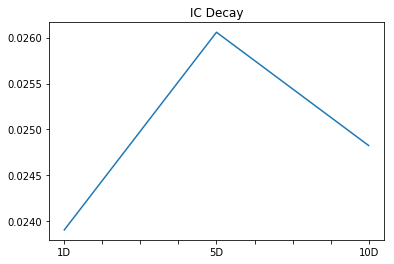

In [88]:
# Before tear sheets, it is in place to check IC mean over time first;
# When the line dips below 0, our alpha factor's predictions stop being useful
alphalens.performance.mean_information_coefficient(merged_data).plot(title="IC Decay")

Quantiles Statistics


min        max      mean       std   count    count %
factor_quantile                                                            
1                0.000000   1.491913  0.364480  0.202412  492002  20.046686
2                0.151579   1.930868  0.684098  0.145341  489544  19.946534
3                0.235448   2.240614  0.864643  0.177637  491389  20.021709
4                0.319258   3.578137  1.092152  0.236973  489545  19.946575
5                0.449243  30.000000  2.085351  1.618460  491801  20.038496

Returns Analysis


1D     5D    10D
Ann. alpha                                      0.183  0.081  0.051
beta                                           -0.021 -0.008 -0.012
Mean Period Wise Return Top Quantile (bps)      7.329  3.081  1.837
Mean Period Wise Return Bottom Quantile (bps)  -6.230 -2.719 -1.699
Mean Period Wise Spread (bps)                  13.560  5.812  3.549

d:\anaconda3\lib\site-packages\alphalens\tears.py:275: UserWarning: 'freq' not set in factor_data index: assuming business day
  UserWarning,


<Figure size 432x288 with 0 Axes>

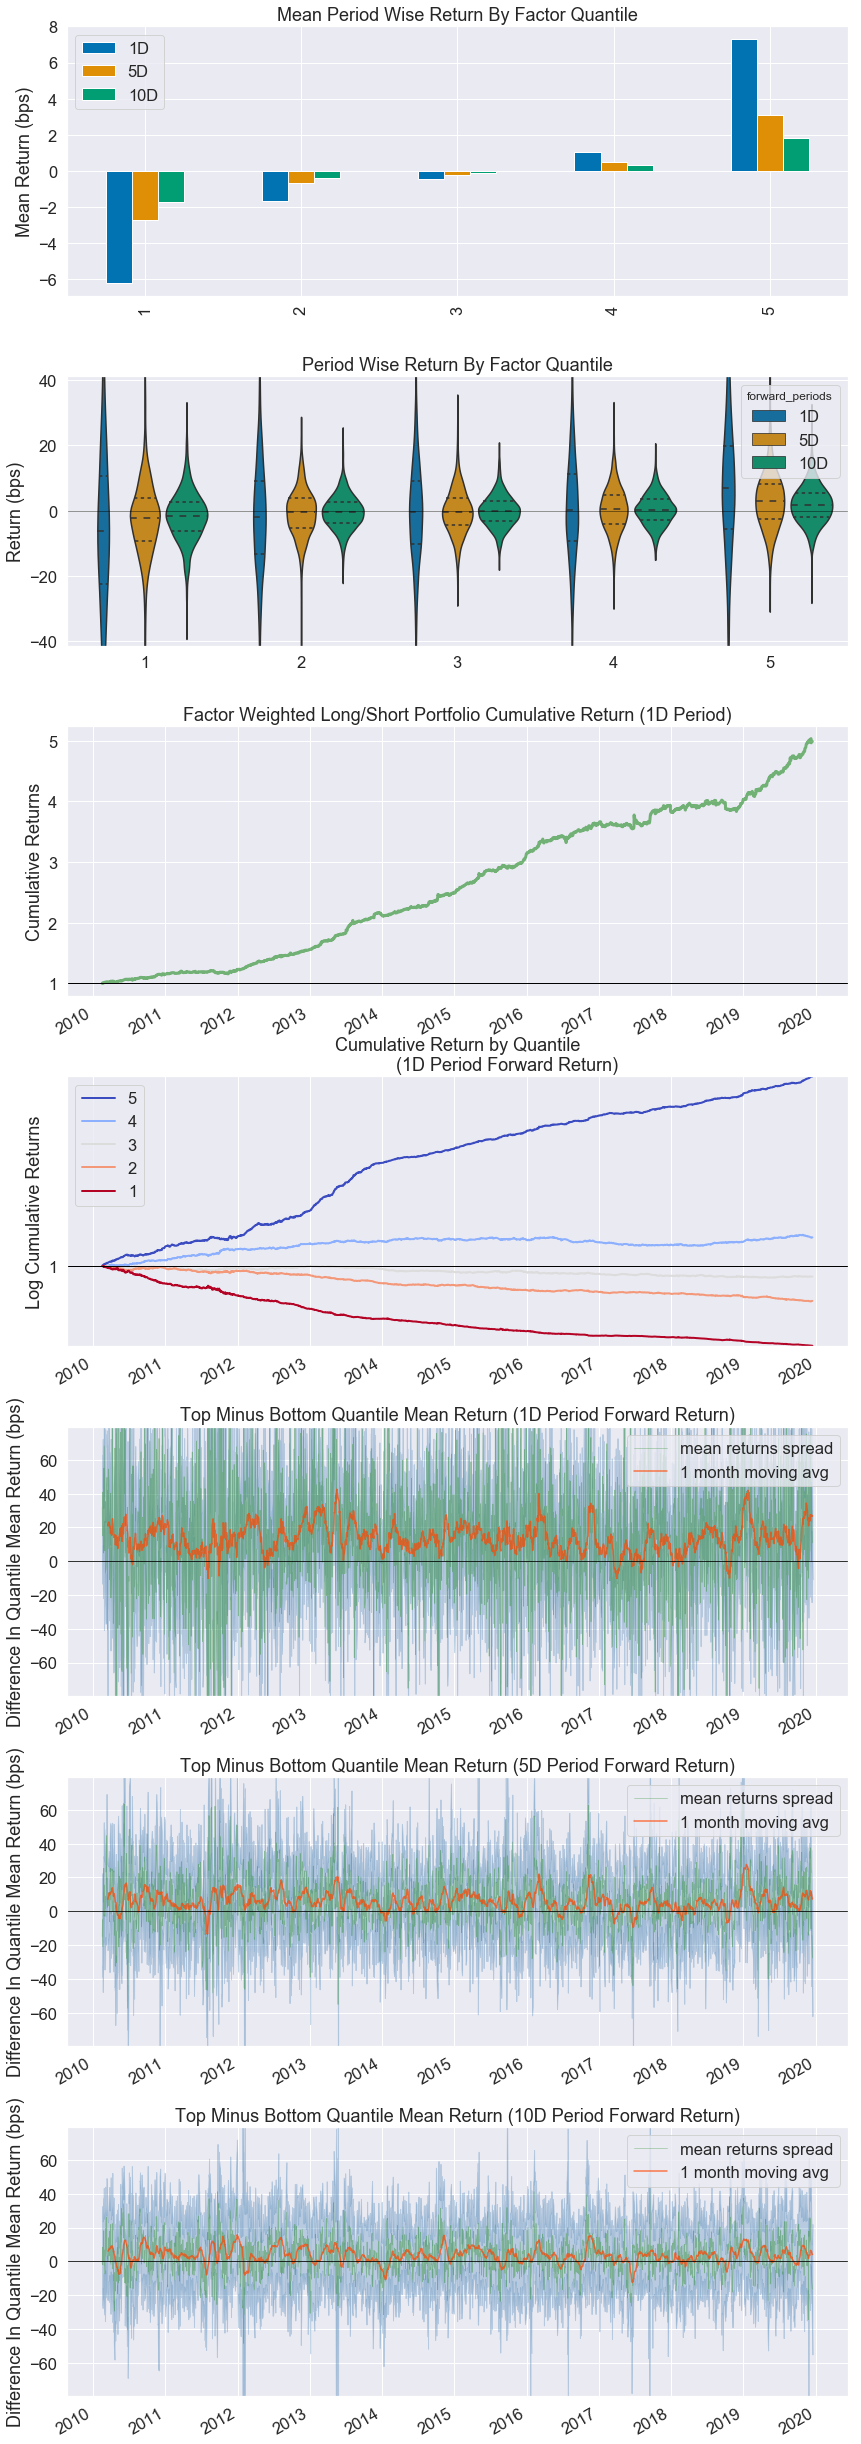

d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Information Analysis


1D      5D     10D
IC Mean           0.024   0.026   0.025
IC Std.           0.059   0.055   0.053
Risk-Adjusted IC  0.407   0.474   0.465
t-stat(IC)          NaN  23.613  23.203
p-value(IC)         NaN   0.000   0.000
IC Skew             NaN   0.044  -0.103
IC Kurtosis         NaN   0.565   0.787

d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


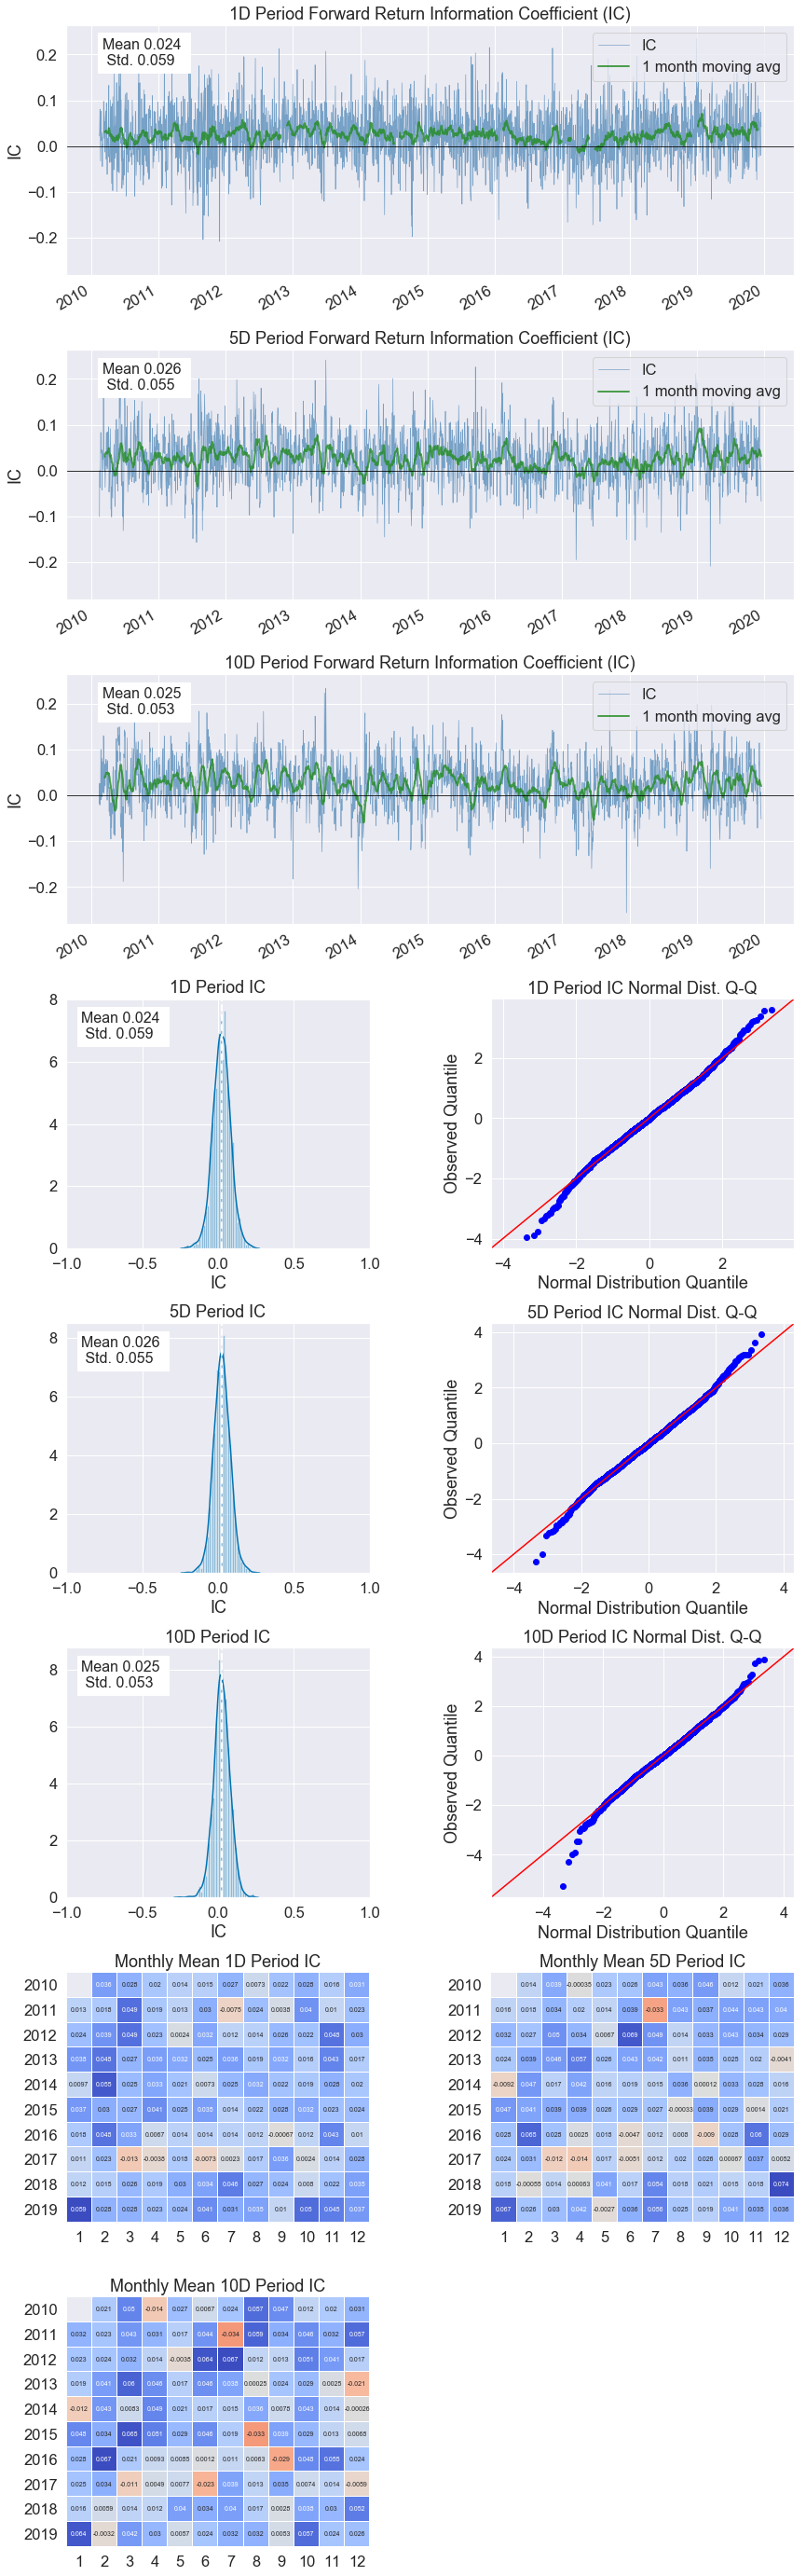

d:\anaconda3\lib\site-packages\alphalens\utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  "Skipping return periods that aren't exact multiples"


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.503  0.592  0.631
Quantile 2 Mean Turnover   0.699  0.761  0.780
Quantile 3 Mean Turnover   0.728  0.764  0.768
Quantile 4 Mean Turnover   0.716  0.758  0.766
Quantile 5 Mean Turnover   0.581  0.746  0.788

1D     5D    10D
Mean Factor Rank Autocorrelation  0.42  0.187  0.095

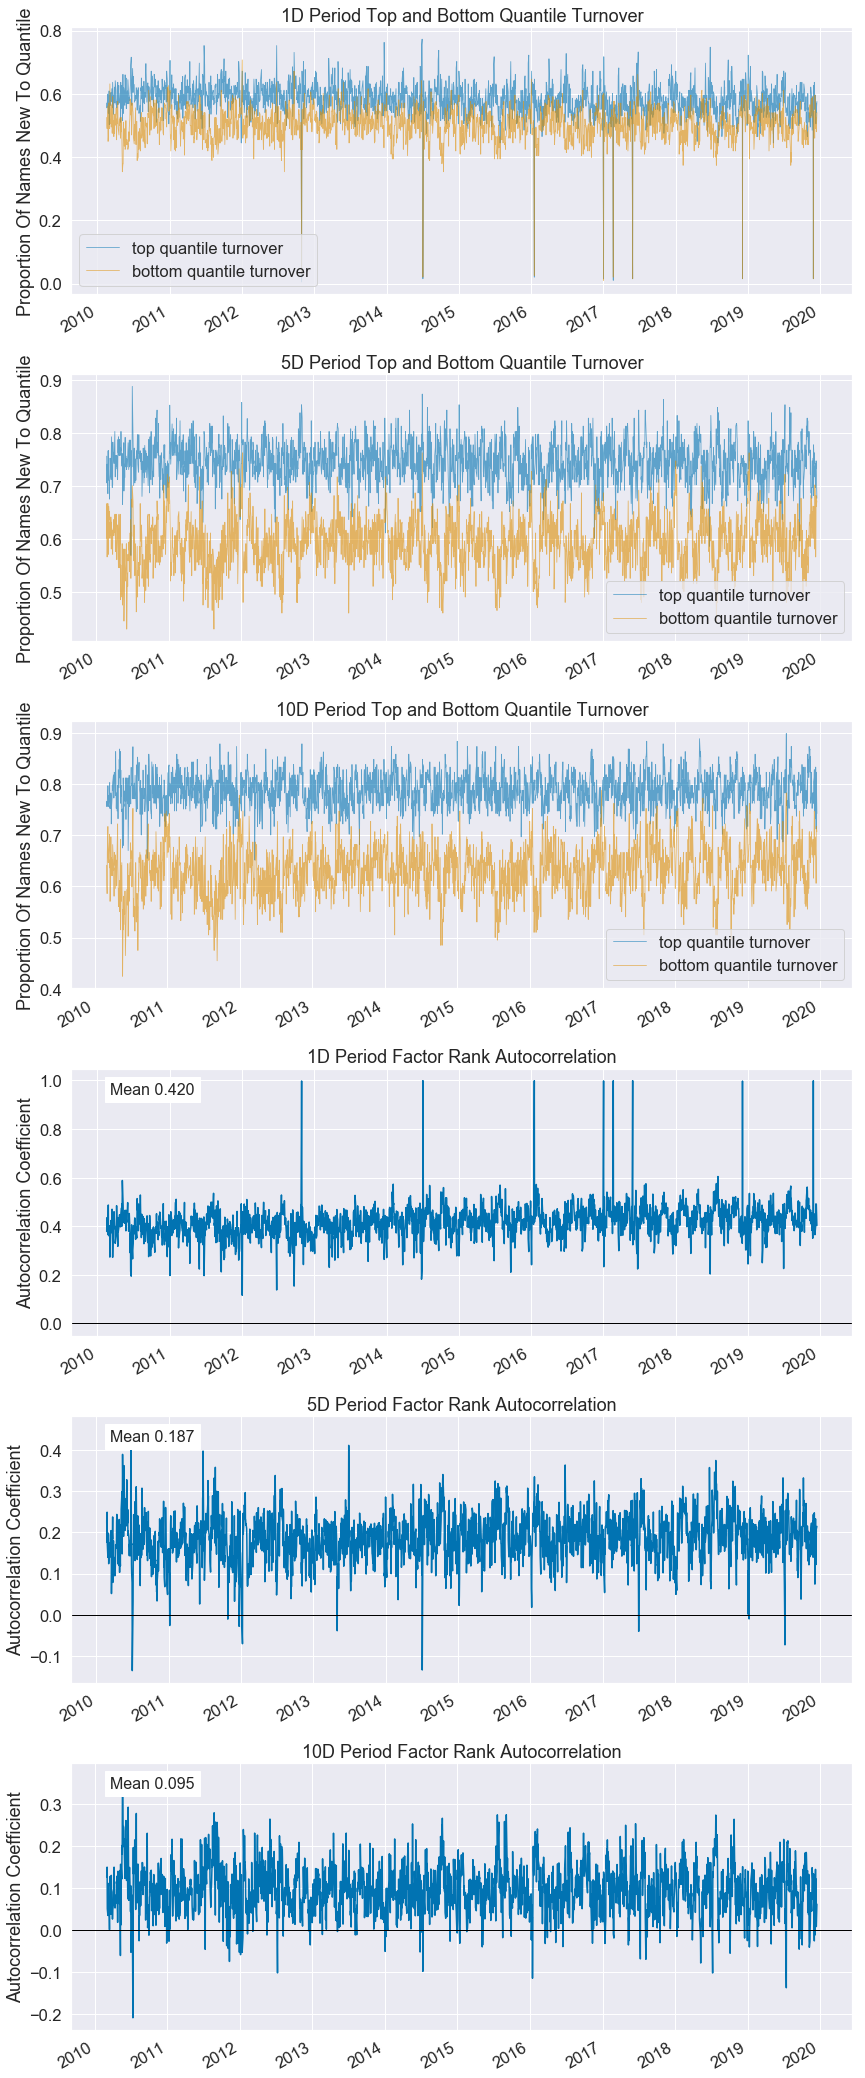

In [100]:
alphalens.tears.create_full_tear_sheet(merged_data, long_short=True, group_neutral=False, by_group=False,)

### Results

Information coefficient (IC) measures correlations between factor values and forward returns. It is positive but not very significant. 

On the other hand, mean return by quantile looks promising; so does the cumulative return by quantile. It suggests higher volumne leads to higher returns.

### Sector Analysis

Now let's check the results by sector.

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min        max      mean       std   count    count %
factor_quantile                                                            
1                0.000000   2.146480  0.383247  0.219456  501944  20.451774
2                0.070886   2.384153  0.685643  0.166282  484059  19.723047
3                0.202336   3.244389  0.867012  0.197015  487542  19.864962
4                0.269400   5.679022  1.092886  0.262500  484058  19.723006
5                0.348552  30.000000  2.060383  1.619026  496678  20.237210

Returns Analysis


1D     5D    10D
Ann. alpha                                      0.137  0.058  0.037
beta                                           -0.007  0.006 -0.001
Mean Period Wise Return Top Quantile (bps)      7.058  2.908  1.788
Mean Period Wise Return Bottom Quantile (bps)  -5.999 -2.559 -1.574
Mean Period Wise Spread (bps)                  13.057  5.478  3.374

d:\anaconda3\lib\site-packages\alphalens\tears.py:275: UserWarning: 'freq' not set in factor_data index: assuming business day
  UserWarning,


<Figure size 432x288 with 0 Axes>

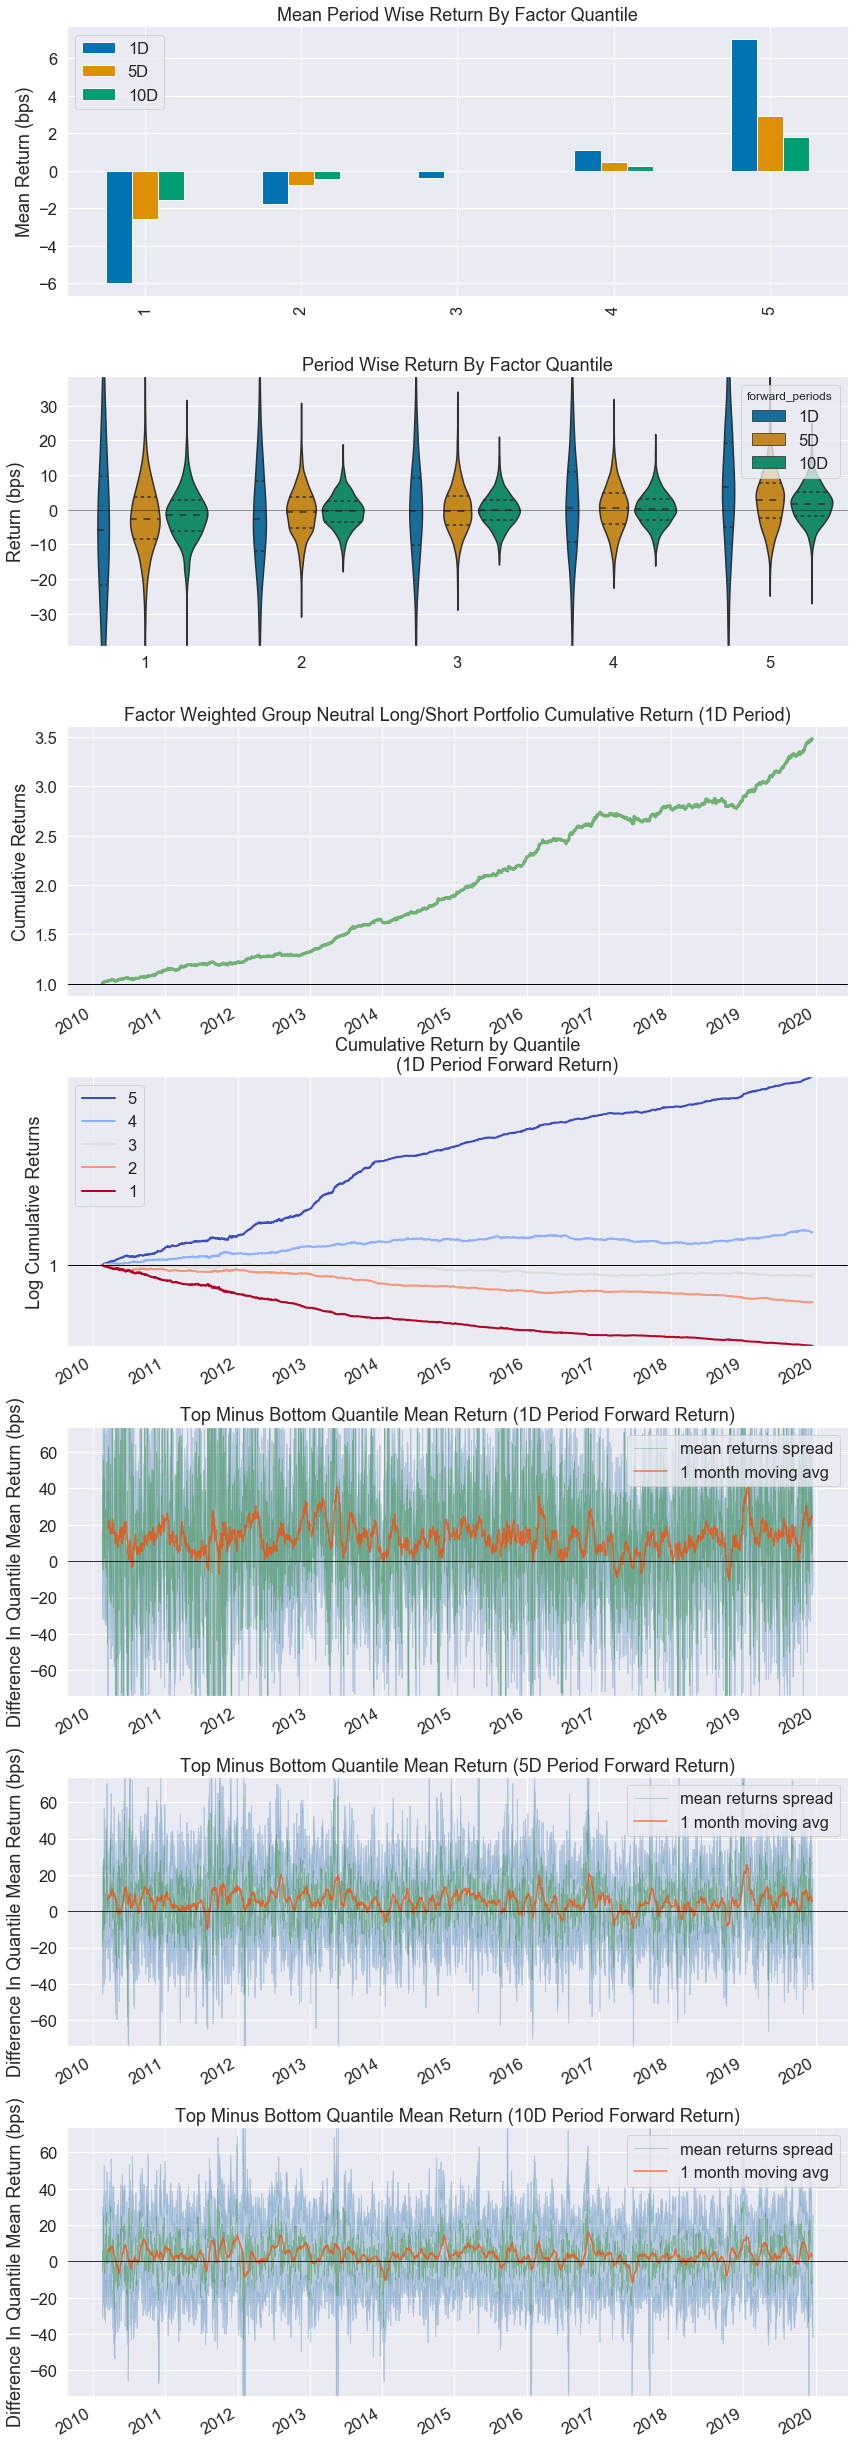

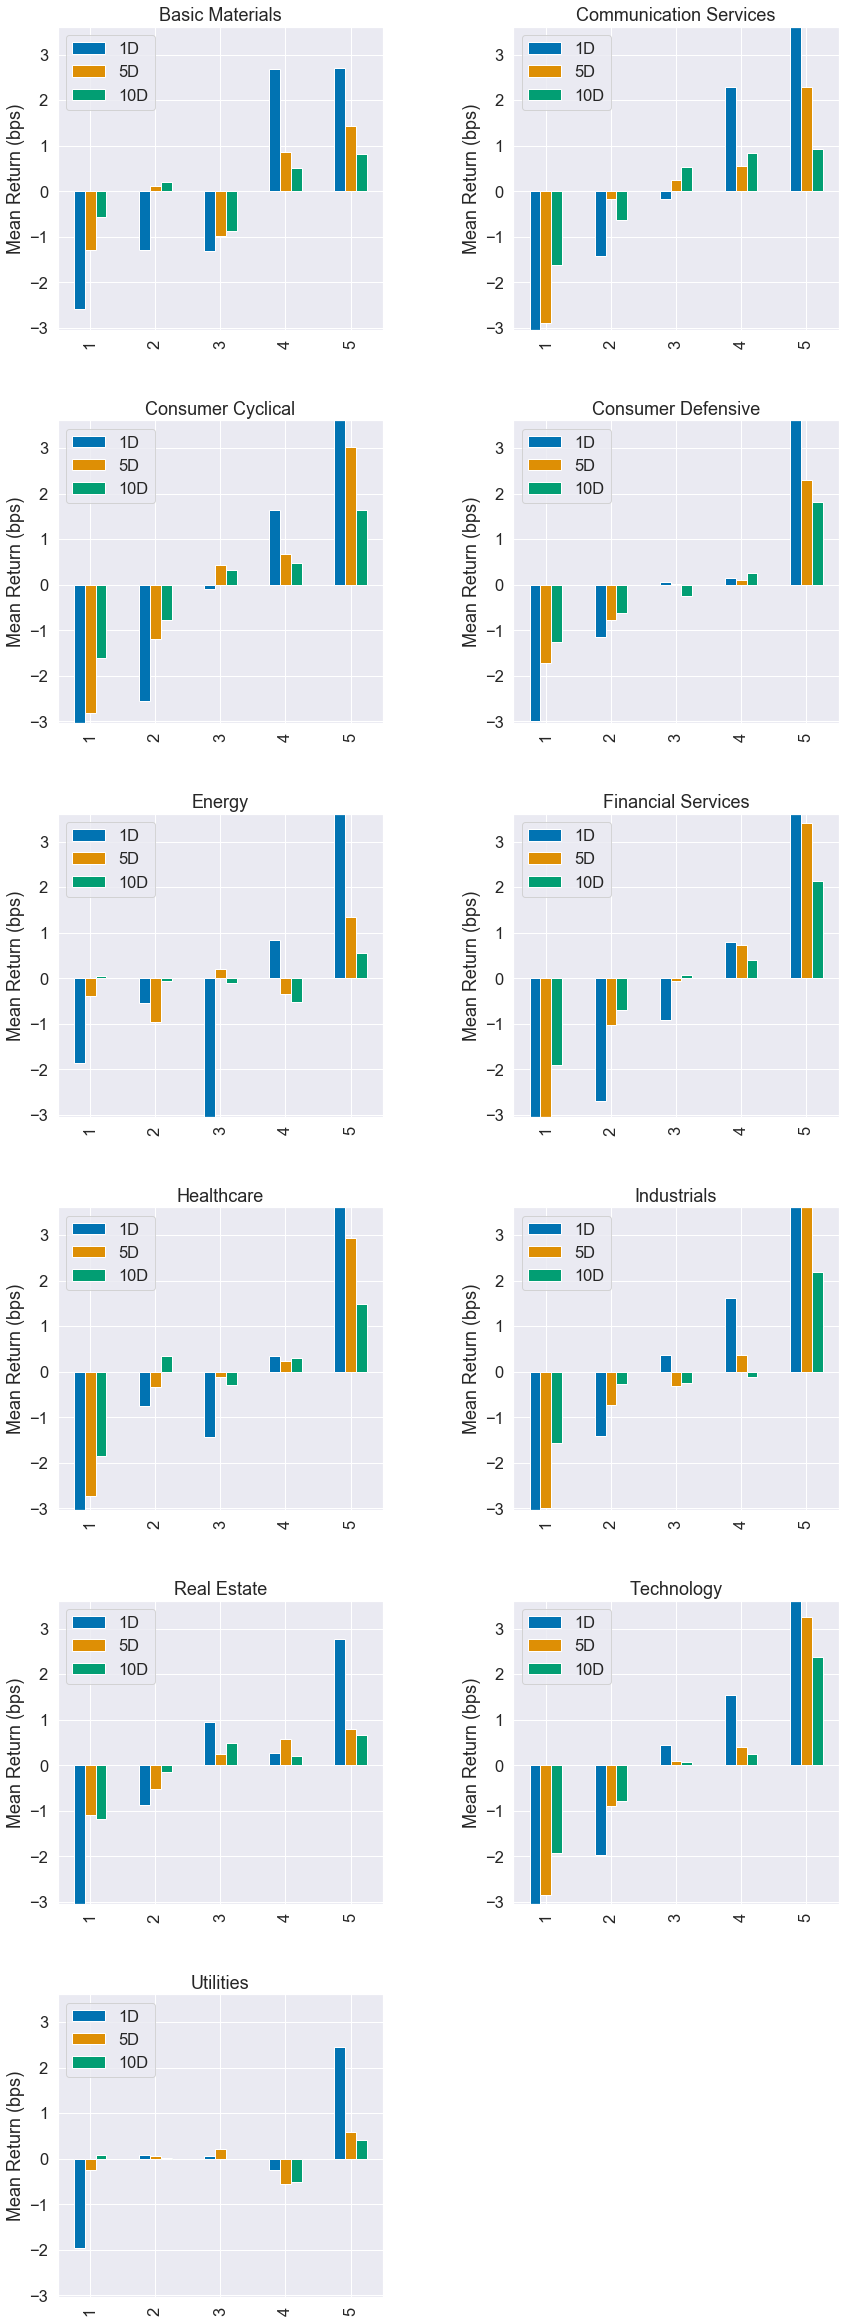

d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Information Analysis


1D      5D     10D
IC Mean           0.024   0.026   0.025
IC Std.           0.055   0.052   0.051
Risk-Adjusted IC  0.431   0.492   0.489
t-stat(IC)          NaN  24.543  24.362
p-value(IC)         NaN   0.000   0.000
IC Skew             NaN   0.063  -0.065
IC Kurtosis         NaN   0.529   0.479

d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
d:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


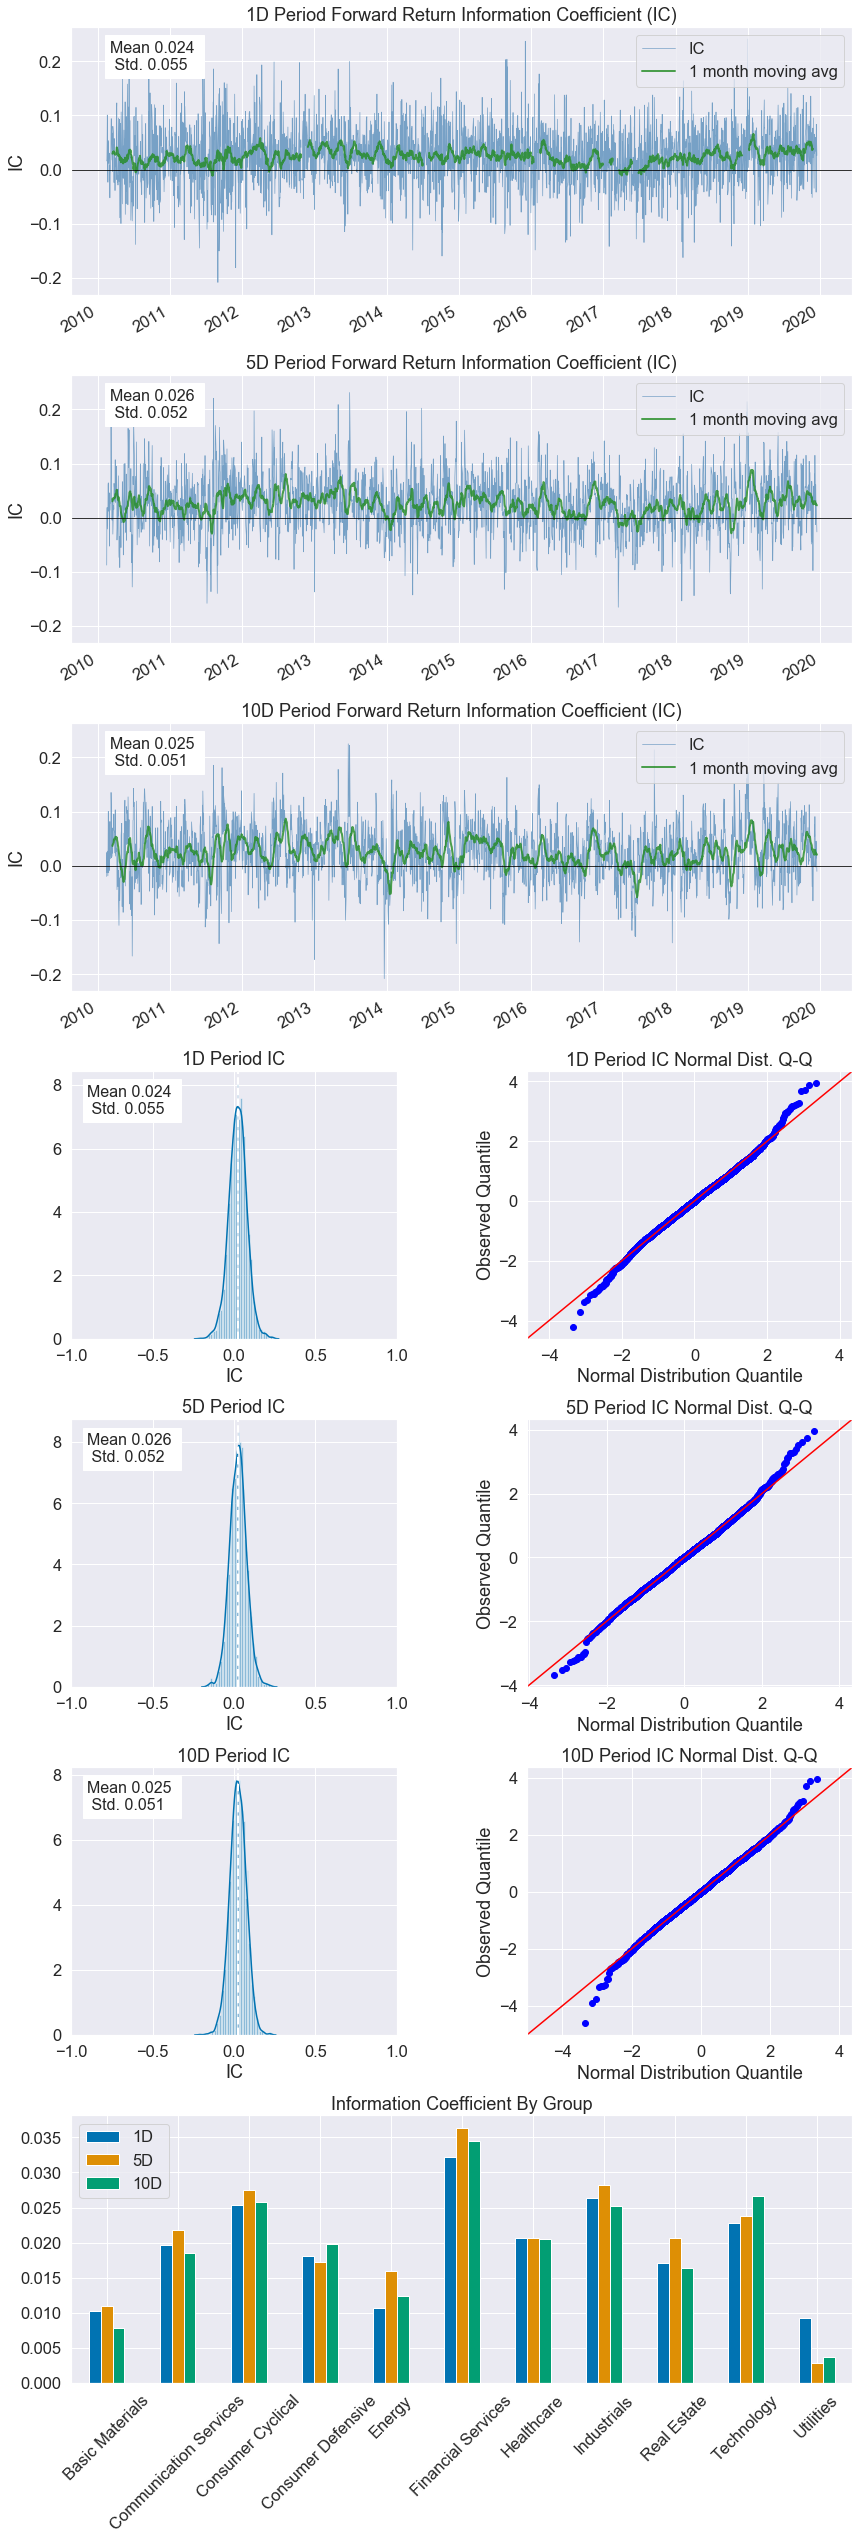

d:\anaconda3\lib\site-packages\alphalens\utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  "Skipping return periods that aren't exact multiples"


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.507  0.600  0.639
Quantile 2 Mean Turnover   0.707  0.766  0.784
Quantile 3 Mean Turnover   0.731  0.766  0.771
Quantile 4 Mean Turnover   0.720  0.761  0.769
Quantile 5 Mean Turnover   0.583  0.745  0.787

1D     5D    10D
Mean Factor Rank Autocorrelation  0.42  0.187  0.095

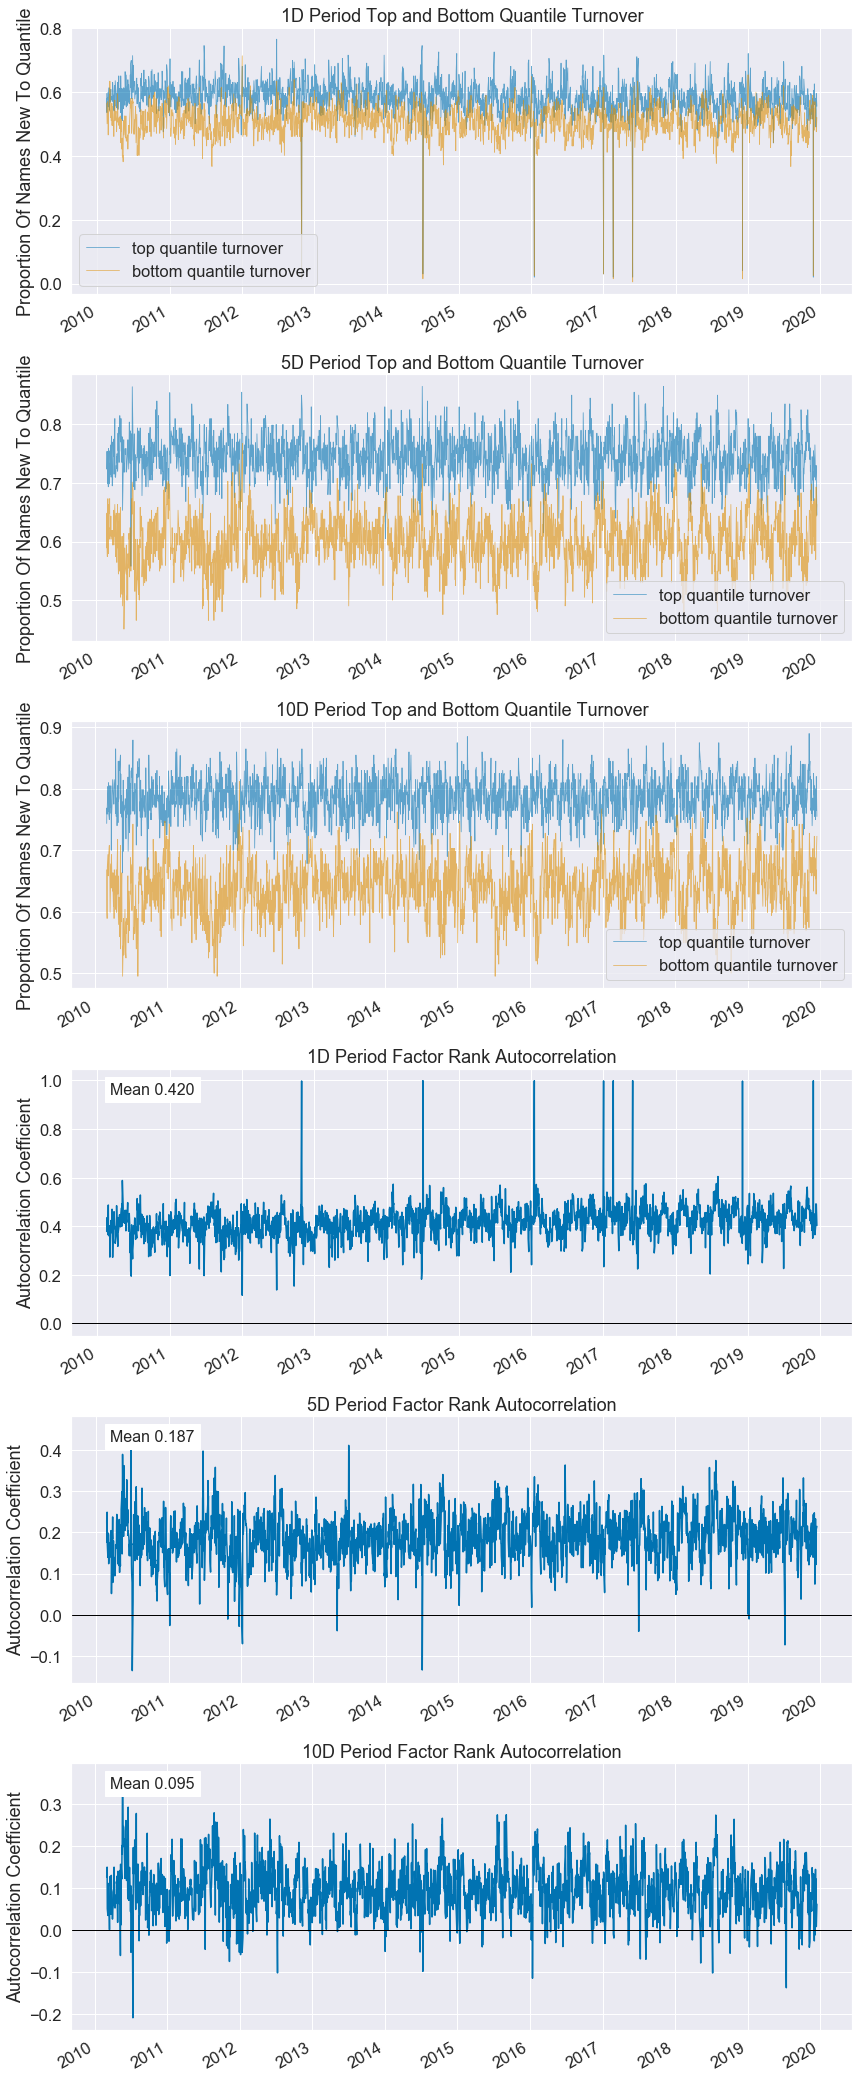

In [102]:
sector_merged_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor=factor.stack(),
    prices=df_prices,
    groupby=dict_sector,
    binning_by_group=True,          # True
    quantiles=5,
    periods=(1,5,10),
    groupby_labels=None,
    cumulative_returns=True
)

alphalens.tears.create_full_tear_sheet(sector_merged_data, long_short=True, by_group=True, group_neutral=True)       # group_neutral